In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import time
import copy
from tqdm.notebook import tqdm
import pandas as pd

# Set device - for MacBook M3 Pro, use MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: mps


In [2]:
# CIFAR-10 mean and std for normalization
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

# Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Test transforms - only normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Load CIFAR-10 dataset
batch_size = 128
num_workers = 4  # Adjust based on your system

# Download and prepare datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Get class names and dataset info
classes = train_dataset.classes
print(f"Classes: {classes}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training set size: 50000
Test set size: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


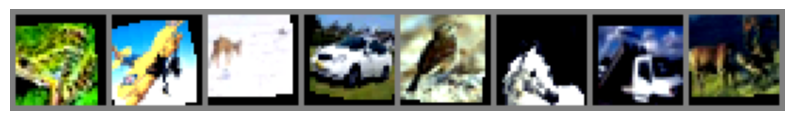

 frog airplane  deer automobile  bird horse truck  deer


In [3]:
# Visualize some training images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


In [4]:
# Load pre-trained ResNet18 model
model = models.resnet18(weights='IMAGENET1K_V1')

# Fine-tuning: keep all parameters trainable
feature_extract = False

# Modify the final fully connected layer for CIFAR-10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, len(classes))
)

# Move model to the appropriate device
model = model.to(device)

# Print model info
print(f"Model: ResNet18 with full fine-tuning")

# Count parameters
total_params = 0
trainable_params = 0

for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")


Model: ResNet18 with full fine-tuning
Total parameters: 11,444,298
Trainable parameters: 11,444,298 (100.00%)


In [5]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer - use Adam for faster convergence
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler - reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20):
    """
    Train the model and return the best model weights
    """
    since = time.time()
    
    # Initialize tracking variables
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            loader = dataloaders[phase]
            pbar = tqdm(loader, total=len(loader))
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                # Track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                pbar.set_description(f'{phase} Loss: {loss.item():.4f}')
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # Use float() instead of double() for MPS compatibility
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Store history for plotting - ensure values are moved to CPU for MPS compatibility
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.detach().cpu().item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.detach().cpu().item())
                # Learning rate scheduler step
                scheduler.step(epoch_loss)
            
            # Deep copy the model if it's the best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return model and history
    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }
    
    return model, history

def test_model(model, dataloader, criterion):
    """
    Test the model on the test set
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    all_preds = []
    all_labels = []
    
    # No gradient calculation needed
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, total=len(dataloader)):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = running_loss / len(dataloader.dataset)
    # Use float() instead of double() for MPS compatibility
    test_acc = running_corrects.float() / len(dataloader.dataset)
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    # Move tensor to CPU before returning for MPS compatibility
    test_acc_cpu = test_acc.detach().cpu().item()
    
    return test_loss, test_acc_cpu, all_preds, all_labels

# Prepare dataloaders dictionary
dataloaders = {
    'train': train_loader,
    'val': test_loader  # Using test set as validation
}


/Users/voldemort/anaconda3/envs/ece60146/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
# Train the model - increase num_epochs for better performance
num_epochs = 20
model_ft, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.1841 Acc: 0.5939


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.9572 Acc: 0.6847

Epoch 2/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.9027 Acc: 0.6945


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7948 Acc: 0.7348

Epoch 3/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.8158 Acc: 0.7249


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7072 Acc: 0.7655

Epoch 4/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.7577 Acc: 0.7459


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6441 Acc: 0.7851

Epoch 5/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.7201 Acc: 0.7559


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6614 Acc: 0.7788

Epoch 6/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6812 Acc: 0.7695


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6125 Acc: 0.7902

Epoch 7/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6548 Acc: 0.7781


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.5744 Acc: 0.8105

Epoch 8/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6299 Acc: 0.7873


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.5552 Acc: 0.8143

Epoch 9/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.6020 Acc: 0.7969


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6204 Acc: 0.7989

Epoch 10/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5948 Acc: 0.7971


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7018 Acc: 0.7802

Epoch 11/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5702 Acc: 0.8060


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.5340 Acc: 0.8205

Epoch 12/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5536 Acc: 0.8094


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.5044 Acc: 0.8338

Epoch 13/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5496 Acc: 0.8150


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.5004 Acc: 0.8326

Epoch 14/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5294 Acc: 0.8188


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.5001 Acc: 0.8312

Epoch 15/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5194 Acc: 0.8217


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.4998 Acc: 0.8312

Epoch 16/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.5036 Acc: 0.8279


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.4871 Acc: 0.8372

Epoch 17/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.4907 Acc: 0.8320


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.4798 Acc: 0.8382

Epoch 18/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.4924 Acc: 0.8323


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.5078 Acc: 0.8364

Epoch 19/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.4676 Acc: 0.8394


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.4769 Acc: 0.8449

Epoch 20/20
----------


  0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 0.4560 Acc: 0.8423


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.4802 Acc: 0.8451

Training complete in 22m 13s
Best val Acc: 0.8451


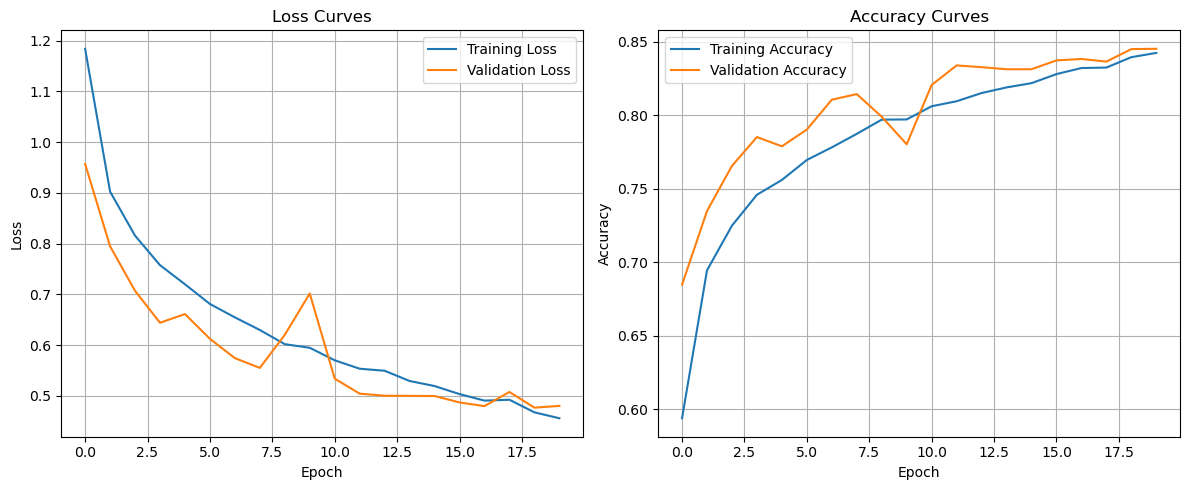

In [7]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


  0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.4802 Acc: 0.8451


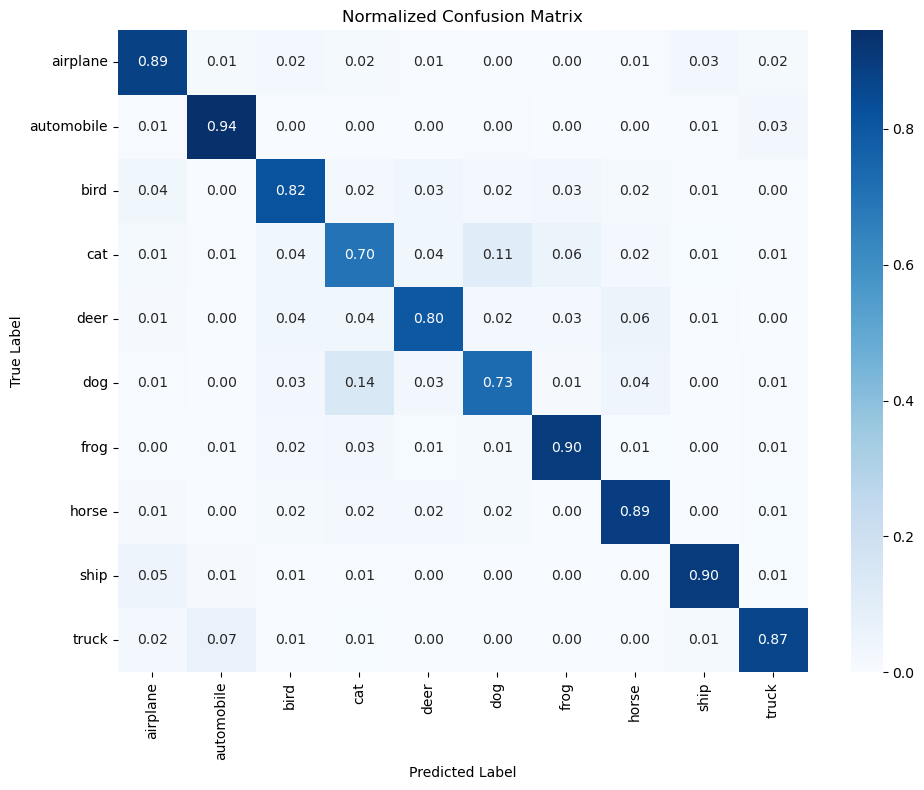

Per-class accuracy:
airplane: 0.8850
automobile: 0.9450
bird: 0.8230
cat: 0.6990
deer: 0.7990
dog: 0.7330
frog: 0.9030
horse: 0.8930
ship: 0.9010
truck: 0.8700

Overall Metrics:
Accuracy: 0.8451
Precision: 0.8446
Recall: 0.8451
F1 Score: 0.8444


In [8]:
# Test the model on the test set
test_loss, test_acc, all_preds, all_labels = test_model(model_ft, test_loader, criterion)

# Plot confusion matrix
import sklearn.metrics as metrics
import seaborn as sns

# Compute confusion matrix
cm = metrics.confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

# Calculate per-class metrics
print("Per-class accuracy:")
for i, class_name in enumerate(classes):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_name}: {class_acc:.4f}")

# Calculate precision, recall, and F1 score
precision = metrics.precision_score(all_labels, all_preds, average='macro')
recall = metrics.recall_score(all_labels, all_preds, average='macro')
f1 = metrics.f1_score(all_labels, all_preds, average='macro')

print(f"\nOverall Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

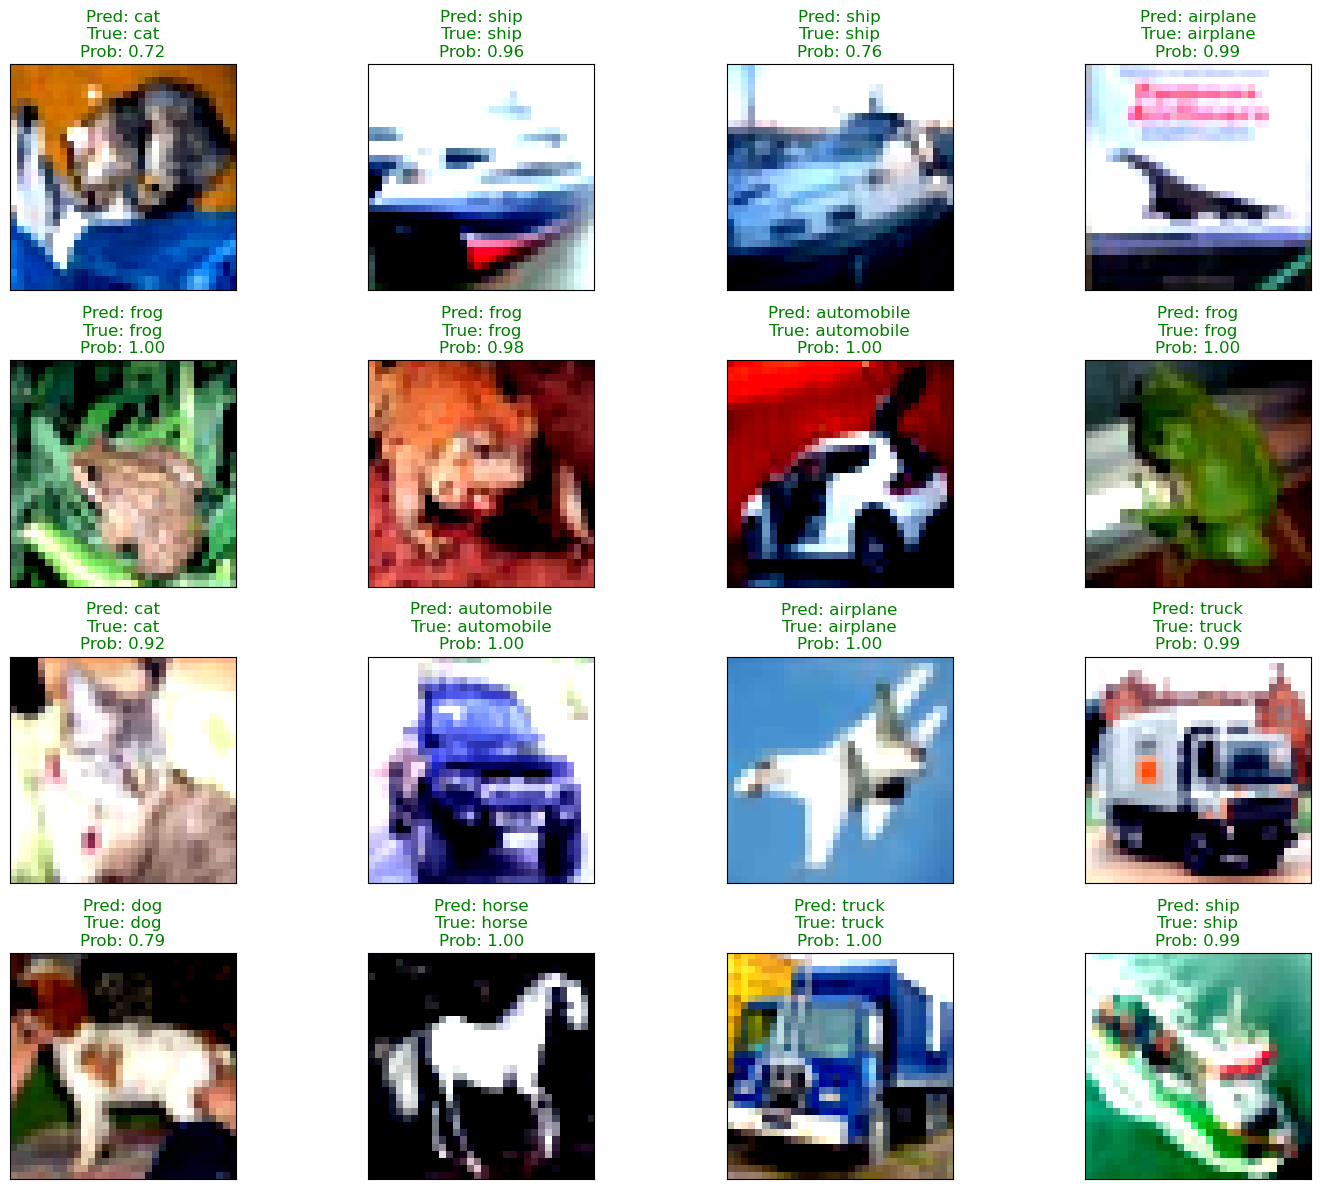

In [9]:
# Function to show images with predictions
def visualize_predictions(model, dataloader, num_images=16):
    # Get a batch of images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    
    # Move tensors to CPU
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()
    probs = probs.cpu()
    
    # Create a grid of images
    fig = plt.figure(figsize=(15, 12))
    
    # Plot at most num_images
    num_to_plot = min(num_images, images.size(0))
    for idx in range(num_to_plot):
        ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
        
        # Display the image
        img = images[idx] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
        # Get prediction information
        pred_class = classes[preds[idx]]
        true_class = classes[labels[idx]]
        prob = probs[idx, preds[idx]].item()
        
        # Set title color based on correct/incorrect prediction
        title_color = 'green' if preds[idx] == labels[idx] else 'red'
        
        # Add title with prediction and confidence
        ax.set_title(f"Pred: {pred_class}\nTrue: {true_class}\nProb: {prob:.2f}", 
                     color=title_color)
    
    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(model_ft, test_loader)


In [10]:
# Create directory for models if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save model
model_save_path = 'models/cifar10_resnet18_finetuned.pth'
torch.save(model_ft.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Save model architecture info
model_info = {
    'architecture': 'ResNet18',
    'num_classes': len(classes),
    'classes': classes,
    'test_accuracy': test_acc
}

import json
with open('models/cifar10_resnet18_model_info.json', 'w') as f:
    json.dump(model_info, f)
    
print("Model info saved to models/cifar10_resnet18_model_info.json")


Model saved to models/cifar10_resnet18_finetuned.pth
Model info saved to models/cifar10_resnet18_model_info.json


In [11]:
def load_model(model_path):
    """
    Load a saved ResNet18 model
    """
    # Create a new model with the same architecture
    model = models.resnet18(weights=None)  # Start with no pre-trained weights
    
    # Modify the final fully connected layer for CIFAR-10 (10 classes)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, len(classes))
    )
    
    # Load the state dict
    model.load_state_dict(torch.load(model_path))
    
    # Move to device
    model = model.to(device)
    
    # Set to evaluation mode
    model.eval()
    
    return model

# Function for making predictions on single images
def predict(model, image_tensor):
    """
    Make a prediction on a single image tensor
    """
    # Add batch dimension and send to device
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    
    # Get prediction info
    pred_class = classes[preds.item()]
    pred_prob = probs[0, preds.item()].item()
    
    return pred_class, pred_prob, probs[0].cpu().numpy()

# Example of loading and using the model (commented out to avoid reloading)
"""
# Load the saved model
loaded_model = load_model('models/cifar10_resnet18_finetuned.pth')

# Get a test image
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[0]

# Make a prediction
pred_class, pred_prob, all_probs = predict(loaded_model, img)

print(f"Predicted class: {pred_class} with probability: {pred_prob:.4f}")
print(f"True class: {classes[labels[0]]}")
"""


'\n# Load the saved model\nloaded_model = load_model(\'models/cifar10_resnet18_finetuned.pth\')\n\n# Get a test image\ndataiter = iter(test_loader)\nimages, labels = next(dataiter)\nimg = images[0]\n\n# Make a prediction\npred_class, pred_prob, all_probs = predict(loaded_model, img)\n\nprint(f"Predicted class: {pred_class} with probability: {pred_prob:.4f}")\nprint(f"True class: {classes[labels[0]]}")\n'